<center><font face='Georgia'> 

# Natural Language Processing. 

    
<center><font size=5 color ='blue' > <i><b>Project<b></i> : Sentiment analysis on Amazon Food Reviews  </center></font>
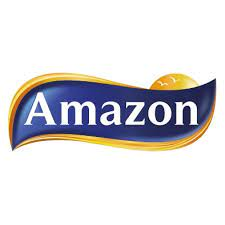
    
Binome
<font color ='red'>    
 1.TOUATI Islem.  
 2.OUCHENE Souhil.
</font>

## Importation des packages et modules :

In [57]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
sns.set()

import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud , STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score , confusion_matrix

## Importation des donnees :

In [58]:
data = pd.read_csv('Amazon_Reviews.csv')
data.head()

,Text,label
0,My four year old Beagle's coat has improved by...,2
1,My cats are kind of finicky and do not like a ...,2
2,I've tried quite a few different energy drinks...,2
3,"<a href=""http://www.amazon.com/gp/product/B000...",2
4,My cats get so high on this stuff it's gotta b...,2


On voit que la variable "Text" necessite un <strong> cleaning </strong> .

## Du plus sur les donnees :
On va essayer d'avoir une idee generale sur notre dataframe(shape, valeurs nulles, valeurs dupliquees, mesures statistiques...)

In [59]:
data.shape

(76493, 2)

In [60]:
data.isnull().sum()

Text     0
label    0
dtype: int64

In [61]:
data.duplicated(subset = ['Text']).sum()

8542

In [62]:
data.drop_duplicates(subset = ['Text'] , keep='first', inplace=True, ignore_index=True)

In [63]:
data.describe()

,label
count,67951.000000
mean,1.654427
std,0.707713
min,0.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,2.000000


In [64]:
data.dtypes

Text     object
label     int64
dtype: object

In [65]:
data['label'].unique()

array([2, 1, 0], dtype=int64)

## Data cleaning :
Le cleaning des donnees text brutes est une étape essentielle dans notre travail ou on essaye d'eliminer les mots et les caracteres inutiles (ponctuation, les caractères speciaux, les chiffres..), ce qui permet d'obtenir de meilleures caracteristiques.


### Removing patterns
Dans cette partie, on va essayer de supprimer tous les caracteres non alphabetiques et les remplacer avec un espace :

In [66]:
data['text_character'] =  data['Text'].str.replace("[^a-zA-Z]", " ")

On va maintenant supprimer les mots ayant une longeur inferieure a 3:

In [67]:
data['text_character'] = data['text_character'].apply(lambda text : ' '.join([w for w in text.split() if len(w)>2]) )

On va rendre tous les caracteres alphabetiques miniscules :

In [68]:
data['text_character'] = data['text_character'].str.lower()

##### Affichage de quelques lignes avant et apres cleaning :

In [69]:
data.head(3)

,Text,label,text_character
0,My four year old Beagle's coat has improved by...,2,four year old beagle coat has improved switchi...
1,My cats are kind of finicky and do not like a ...,2,cats are kind finicky and not like lot wet foo...
2,I've tried quite a few different energy drinks...,2,tried quite few different energy drinks and re...


## Sentiment Analysis 

Dans cette partie, on va mesurer quelque indicateurs necessaires a notre analyse :
- La polarité qui mesure le sentiment d'un texte comme étant positif, négatif ou neutre.
- La subjectivité qui mesure le niveau de subjectivité d'un texte, qu'il soit objectif (basé sur des faits) ou subjectif (basé sur des opinions).

### Polarity and Subjectivity

In [70]:
data['Polarity'] = [ TextBlob(text).sentiment[0] for text in data['text_character']]
data['Subjectivity'] = [ TextBlob(text).sentiment[1] for text in data['text_character']]

In [71]:
data.head(3)

,Text,label,text_character,Polarity,Subjectivity
0,My four year old Beagle's coat has improved by...,2,four year old beagle coat has improved switchi...,0.149653,0.404514
1,My cats are kind of finicky and do not like a ...,2,cats are kind finicky and not like lot wet foo...,0.005000,0.616667
2,I've tried quite a few different energy drinks...,2,tried quite few different energy drinks and re...,0.218750,0.500000


### Sentiment intensity
On doit maintenant savoir le Sentiment Intensity qui fait référence a la force ou à l'amplitude d'un sentiment exprime dans un texte. Il s'agit d'un score allant de tres negatif à tres positif. elle fournit des informations sur une classification des sentiments (positif, négatif, neutre).

On va utiliser le modele : SentimentIntensityAnalyzer()

In [72]:
SIA = SentimentIntensityAnalyzer()

neg = [ SIA.polarity_scores(text)['neg'] for text in data['text_character']]
pos = [ SIA.polarity_scores(text)['pos'] for text in data['text_character']]
neu = [ SIA.polarity_scores(text)['neu'] for text in data['text_character']]

On rajoute ces colonnes a notre dataframe, et on affiche qulques lignes :

In [73]:
df = pd.DataFrame()
df['neg'] = neg
df['pos'] = pos
df['neu'] = neu
df.head()

,neg,pos,neu
0,0.073,0.130,0.796
1,0.103,0.176,0.721
2,0.075,0.208,0.717
3,0.026,0.202,0.772
4,0.177,0.096,0.727


On va maintenant classer nos text selon leur polarity (Negative, Neutre, Positive). Il existe plusieurs aproches pour se faire, mais on a opte pour le <strong> max </strong> . 

In [74]:
sentiment = []

for index in range(df.shape[0]):
    a = list(df.loc[index])
    m = max(a)
    i = a.index(m)
    if ( i==0) :
        sentiment.append('Negative')
    elif (i==1):
        sentiment.append('Positive')
    else :
        sentiment.append('Neutre')

On rajoute une colonne (sentiment) a notre dataframe qui represente la classification de notre message selon sa polarite, puis calculer la probabilte d'occurence de chaque classe :

In [75]:
data['sentiment'] = sentiment
data['sentiment'].value_counts(normalize=True)

Neutre      0.928610
Positive    0.070801
Negative    0.000589
Name: sentiment, dtype: float64

Pour mieux visualiser nos resultats, on utilise un pie chart qui represente les proportions de chaque classe :

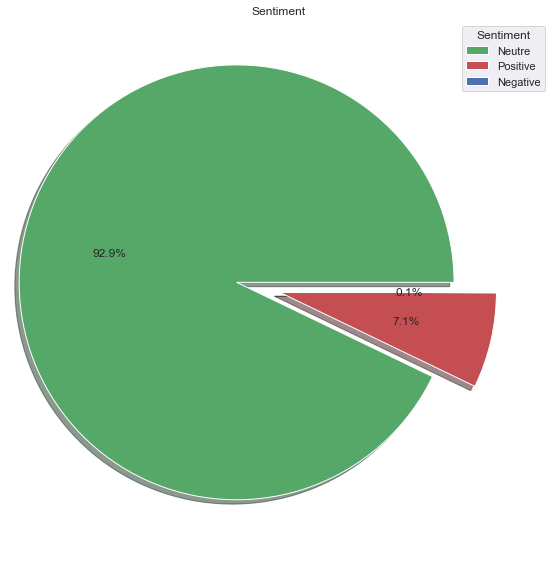

In [76]:
fig=plt.figure(figsize=(10, 10))

plt.pie(data['sentiment'].value_counts(),
        explode = [0.2, 0 ,0], 
        shadow = True,
        autopct='%1.1f%%',
        colors=['g', "r" ,"b"])
plt.legend(title="Sentiment", labels=['Neutre', 'Positive' , 'Negative'])
plt.title('Sentiment')
plt.show()

Comme on peut voir :
- la majorite des texts sont de polarite neutre.
- d'une facon moins importante, positive.
- Negative : presque nulle.

### Stemming

Stemming est un processus qui consiste à reduire les mots a leur forme de base(racine). Son objectif est de normaliser les mots a leur forme de base afin que les mots qui ont la même signification soient traites comme le meme mot : on met l'accent sur le sens des mots et non sur leur forme specifique.

Mais, on a seulement des text (phrases), alors on va d'abord les tokenizer (diviser nos phrases(text) en mots(notre cas)).

In [77]:
# Tokenization + affichage :
all_text = data['text_character'].apply(lambda x : word_tokenize(x))
all_text

0        [four, year, old, beagle, coat, has, improved,...
1        [cats, are, kind, finicky, and, not, like, lot...
2        [tried, quite, few, different, energy, drinks,...
3        [href, http, www, amazon, com, product, xbf, d...
4        [cats, get, high, this, stuff, got, ta, illega...
                               ...                        
67946    [try, eat, healthy, which, means, having, eat,...
67947    [this, tea, great, little, sweet, tastes, grea...
67948    [omg, when, first, heard, crystal, light, pomt...
67949    [first, tried, this, coffee, serbia, wonderful...
67950    [never, met, mio, product, that, isn, deliciou...
Name: text_character, Length: 67951, dtype: object

Pour le Stemming, on va utiliser PorterStemmer(), et puis on va afficher nos resultats :

In [78]:
porter = PorterStemmer() 
stemmed_text = all_text.apply(lambda x: [porter.stem(i) for i in x]) 
stemmed_text

0        [four, year, old, beagl, coat, ha, improv, swi...
1        [cat, are, kind, finicki, and, not, like, lot,...
2        [tri, quit, few, differ, energi, drink, and, r...
3        [href, http, www, amazon, com, product, xbf, d...
4        [cat, get, high, thi, stuff, got, ta, illeg, o...
                               ...                        
67946    [tri, eat, healthi, which, mean, have, eat, br...
67947    [thi, tea, great, littl, sweet, tast, great, k...
67948    [omg, when, first, heard, crystal, light, pomt...
67949    [first, tri, thi, coffe, serbia, wonder, but, ...
67950    [never, met, mio, product, that, isn, delici, ...
Name: text_character, Length: 67951, dtype: object

On va maintenant reconstituer nos phrases apres stemming :

In [79]:
for i in range(len(data)):
    stemmed_text[i] = ' '.join(stemmed_text[i])    
data['text_character'] = stemmed_text

In [80]:
data.head()

,Text,label,text_character,Polarity,Subjectivity,sentiment
0,My four year old Beagle's coat has improved by...,2,four year old beagl coat ha improv switch from...,0.149653,0.404514,Neutre
1,My cats are kind of finicky and do not like a ...,2,cat are kind finicki and not like lot wet food...,0.005000,0.616667,Neutre
2,I've tried quite a few different energy drinks...,2,tri quit few differ energi drink and redlin th...,0.218750,0.500000,Neutre
3,"<a href=""http://www.amazon.com/gp/product/B000...",2,href http www amazon com product xbf dorito to...,0.242308,0.439560,Neutre
4,My cats get so high on this stuff it's gotta b...,2,cat get high thi stuff got ta illeg one them r...,0.034143,0.510143,Neutre


###  Quelques Visualizations :
On va d'abord utiliser le WordCloud pour visualiser les mots les plus fréquents dans nos texts(Taille) et le sentiment associe e chaque mot (couleurs).

On va d'abord fusionner tous nos texts en une seule liste qui sera argument du WordCloud :

In [81]:
all_words = ''.join([text for text in data['text_character']])

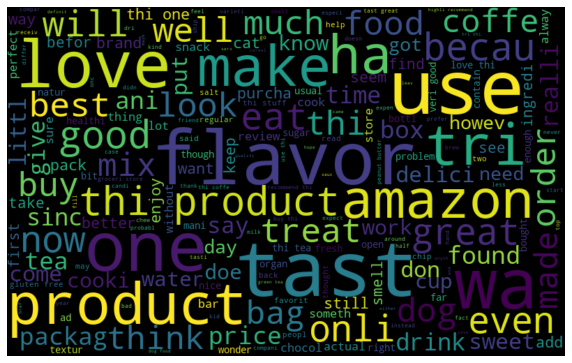

In [82]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

Comme on peut voir dans cette figure, nos resultats sont confirmes, On a une majorite de neutral/positive reviews (jaune, bleu et vert) avec une abscence de mots negatifs (pas de rouge, orange ou noir),  et la taille de chaque mot represente sa frequence : tast, love, use, flavor ... les plus frequents.

#### Removing StopWords
Dans cette partie, on veut se concentrer seulement sur les mots les plus significatifs et pertinents de nos donnees. Alors on va supprimer les mots qui n'ont pas une grande importance surtout pour le food reviews. 

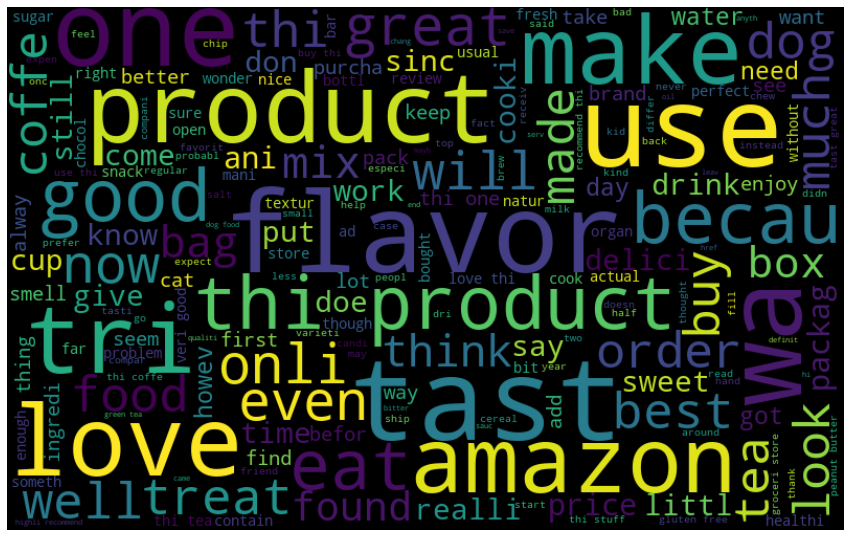

In [83]:
# liste deja predefinie :
my_stopwords = set(STOPWORDS)
#maj de la liste :
my_stopwords.update(["ha"])
my_cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110 , stopwords=my_stopwords).generate(all_words)
plt.figure(figsize=(15, 15)) 
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

### Some Machine Learning :
Le but de notre etude est d'essayer de predire le sentiment a partir d'un nouveau text comme entree, c'est pour cela on va generer plusieurs modeles(Regresion logistique, XGB) a l'aide de differentes methodes pour vectorisation(Bag-Of-Words, TF-IDF)

On doit d'abord choisir les colonnes avec lesquelles on va continuer notre travail :
- text_character : le text qu'on a deja traite.
- label : c'est le sentiment, (0 : negatif),(1 : neutre) et (2 : positif)

In [91]:
data = data[['text_character' , 'label']]
data

,text_character,label
0,four year old beagl coat ha improv switch from...,2
1,cat are kind finicki and not like lot wet food...,2
2,tri quit few differ energi drink and redlin th...,2
3,href http www amazon com product xbf dorito to...,2
4,cat get high thi stuff got ta illeg one them r...,2
...,...,...
67946,tri eat healthi which mean have eat brown rice...,2
67947,thi tea great littl sweet tast great kid like ...,2
67948,omg when first heard crystal light pomtini the...,2
67949,first tri thi coffe serbia wonder but you can ...,2


# Vectorization : 
La vectorisation de texte est le processus de conversion de donnees textuelles en vecteurs ou matrices numeriques qui peuvent etre utilises comme entrees pour les algorithmes du ML. Cette operation est necessaire car la plupart des algorithmes d'apprentissage automatique ne peuvent pas travailler directement avec des donnees textuelles et ont besoin de representations numeriques. Elle peut être réalisée à l'aide de différentes techniques :
- Le Bag-of-Words (BoW)
- term frequency-inverse document frequency (TF-IDF)

## Bag-Of-Words features (BOW)
Le Bag-of-Words (BoW) est une méthode permettant de représenter un texte sous forme de vecteur numérique en comptant la fréquence des mots (ou "tokens") dans un document. Le vecteur résultant représente la présence et la fréquence des mots dans un document.

In [85]:
vect = CountVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words='english') 
X = vect.fit_transform(data['text_character'])
X.shape

(67951, 1000)

## Spliting our data to train & test  sets :

In [92]:
X_train , X_test , Y_train , Y_test = train_test_split(X , data['label'] , test_size =0.2 , random_state = 45)

Commencons par le modele de regression logistique : 

### Logistic regression

In [93]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train , Y_train)
Y_predict = logistic_model.predict(X_test)

C:\Users\Computer House\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precision du modele : 

In [94]:
print('Accuracy score on test data: ', accuracy_score(Y_test, Y_predict))

Accuracy score on test data:  0.8472518578471047


La matrice de Confusion :

In [95]:
matrix_log = confusion_matrix(Y_test, Y_predict)
matrix_log

array([[ 1017,    85,   801],
       [  182,    97,   655],
       [  250,   103, 10401]], dtype=int64)

Affichage propre :

In [96]:
cm_df = pd.DataFrame(matrix_log)
cm_df.columns = ['Predicted 0','Predicted 1','Predicted 2']
cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1',2:'Actual 2'})
cm_df

,Predicted 0,Predicted 1,Predicted 2
Actual 0,1017,85,801
Actual 1,182,97,655
Actual 2,250,103,10401


Le 2eme modele est XGB :

## XGB model 

In [44]:
XGB_model = XGBClassifier(n_estimators=1000)
XGB_model.fit(X_train , Y_train)
Y_pred_XGB =XGB_model.predict(X_test)

La precision du modele : 

In [45]:
print('Accuracy score on test data: ', accuracy_score(Y_test, Y_pred_XGB))

Accuracy score on test data:  0.8512986535207122


Matrice de Confusion :

In [46]:
matrix_XGB = confusion_matrix(Y_test, Y_pred_XGB)
matrix_XGB

array([[ 1076,    87,   740],
       [  187,   114,   633],
       [  277,    97, 10380]], dtype=int64)

Affichage propre :

In [97]:
cm_df_XGB = pd.DataFrame(matrix_XGB)
cm_df_XGB.columns = ['Predicted 0','Predicted 1','Predicted 2']
cm_df_XGB = cm_df_XGB.rename(index={0: 'Actual 0',1:'Actual 1',2:'Actual 2'})
cm_df_XGB

,Predicted 0,Predicted 1,Predicted 2
Actual 0,1076,87,740
Actual 1,187,114,633
Actual 2,277,97,10380


## TF-IDF 
L'indice BoW est une représentation simple mais efficace qui peut être améliorée en ajoutant des fonctionnalités telles que la fréquence des termes dans l'inverse de la fréquence des documents (TF-IDF) pour pondérer davantage les mots plus rares.

TF-IDF est une statistique numérique qui reflète l'importance d'un mot pour un document dans une collection ou un corpus. Elle est le produit de deux métriques : la fréquence des termes (TF) et la fréquence inverse des documents (IDF). TF mesure la fréquence d'un mot dans un document, tandis que IDF mesure la rareté du mot dans tous les documents. Plus la valeur TF-IDF est élevée, plus le mot est important dans le document. Elle est utilisée pour les tâches de recherche d'informations et d'exploration de textes, telles que la classification de textes, le regroupement de textes et les comparaisons de similarité de documents.

In [98]:
vect_tf = TfidfVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words='english') 
X_tf = vect.fit_transform(data['text_character'])
X_tf.shape

(67951, 1000)

## Spliting our data to train & test  sets :

In [99]:
X_train , X_test , Y_train , Y_test = train_test_split(X_tf , data['label'] , test_size =0.2 , random_state = 45)

Commencons par le modele de regression logistique : 

### Logistic regression 

In [100]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train , Y_train)
Y_predict = logistic_model.predict(X_test)

C:\Users\Computer House\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precision du modele : 

In [50]:
print('Accuracy score on test data: ', accuracy_score(Y_test, Y_predict))

Accuracy score on test data:  0.8472518578471047


Matrice de Confusion

In [51]:
matrix_log = confusion_matrix(Y_test, Y_predict)
matrix_log

array([[ 1017,    85,   801],
       [  182,    97,   655],
       [  250,   103, 10401]], dtype=int64)

Affichage plus propre :

In [52]:
cm_df_log = pd.DataFrame(matrix_log)
cm_df_log.columns = ['Predicted 0','Predicted 1','Predicted 2']
cm_df_log = cm_df_log.rename(index={0: 'Actual 0',1:'Actual 1',2:'Actual 2'})
cm_df_log

,Predicted 0,Predicted 1,Predicted 2
Actual 0,1017,85,801
Actual 1,182,97,655
Actual 2,250,103,10401


## modele XGB 

In [53]:
XGB_model = XGBClassifier(n_estimators=1000)
XGB_model.fit(X_train , Y_train)
Y_pred_XGB =XGB_model.predict(X_test)

La precision du modele : 

In [54]:
print('Accuracy score on test data: ', accuracy_score(Y_test, Y_pred_XGB))

Accuracy score on test data:  0.8512986535207122


Matrice de Confusion :

In [55]:
matrix_XGB_tf = confusion_matrix(Y_test, Y_pred_XGB)
matrix_XGB_tf

array([[ 1076,    87,   740],
       [  187,   114,   633],
       [  277,    97, 10380]], dtype=int64)

Affichage propre :

In [101]:
cm_df_XGB_tf = pd.DataFrame(matrix_XGB)
cm_df_XGB_tf.columns = ['Predicted 0','Predicted 1','Predicted 2']
cm_df_XGB_tf = cm_df_XGB_tf.rename(index={0: 'Actual 0',1:'Actual 1',2:'Actual 2'})
cm_df_XGB_tf

,Predicted 0,Predicted 1,Predicted 2
Actual 0,1076,87,740
Actual 1,187,114,633
Actual 2,277,97,10380


## Conclusion :
Le meilleur modele(en performance) est celui de XGB avec un score de precision de 85.1%